In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dill
import random
from scipy.interpolate import CubicSpline

Function to extract temperatures at sensor locations from the calculated temperature profiles

In [2]:
def get_measured_temperatures(T_end,sensor_depths, sensor_std, z_grid, used_profiles):
    measured_temperatures = []
    randListIndex= sensor_depths.shape[0]
    #    Random errors are used in the case of device error accross the senors is given (i.e., sensor_std!=0) 
    #    otherwise sensor_std=0
    randList=np.load('./code/RandomLists_device_error/RandomLists_%dsensor_randn_diff_90.npy'%(randListIndex))
    for p in used_profiles:
        spline = CubicSpline(z_grid, T_end[:,p])
        evaluated_sensor = spline(sensor_depths)+(sensor_std*randList[p,:])
        measured_temperatures.append(evaluated_sensor)
        
    return measured_temperatures

Function to reconstruct from the sensor measurements continuous temperature profiles using interpolation.

In [3]:
def build_interpolants(T_end,sensor_depths, measured_temperatures,used_profiles):
    interpolants = []
    for i in range(len(used_profiles)):
        interpolants.append(CubicSpline(sensor_depths, measured_temperatures[i]))
    return interpolants

Function to calculate error between calculated temperature profiles and reconstructed temperature profiles

In [4]:
def evaluate_measurement_errors(interpolants, z_grid, error_grid, T_end, used_profiles):
    errors = []
    i = 0
    for p in used_profiles:
        T_end_interpolant = CubicSpline(z_grid, T_end[:,p])
        errors.append(np.abs(interpolants[i](error_grid) - T_end_interpolant(error_grid)))
        i = i + 1
    return errors

Combine all steps in one "analysis" function

In [5]:
def do_sensor_analysis(T_end,sensor_depths, sensor_std, z_grid, error_grid, used_profiles):
    measured_temperatures = get_measured_temperatures(T_end,sensor_depths, sensor_std, z_grid, used_profiles)
    interpolants = build_interpolants(T_end,sensor_depths, measured_temperatures, used_profiles)
    errors = evaluate_measurement_errors(interpolants, z_grid, error_grid, T_end, used_profiles)

    accumulated_error = np.zeros(errors[0].size)
    for i in range(len(used_profiles)):
        accumulated_error = accumulated_error + (errors[i]**2)

    accumulated_error = np.sqrt(accumulated_error / len(used_profiles))


    return accumulated_error,errors

Function to generate a sensor placement that minimizes the variance in the error by sequentially adding sensors at locations of maximum error variance.

In [6]:
def get_inner_sensors(sensor_min_depth,sensor_max_depth):
    
    import numpy as np
    from scipy.stats import qmc
    
    sample_qmch=np.load('./code/halton_samples_sensors.npy',allow_pickle=True)

    l_bounds = [sensor_min_depth]
    u_bounds = [sensor_max_depth]
    sample_scaled = qmc.scale(sample_qmch, l_bounds, u_bounds)
    
    
    sample_select=[]
    
    while(len(sample_select) != 2):
        si=random.randrange(100000)
        if (sample_scaled[si] != sensor_min_depth and sample_scaled[si] != sensor_max_depth):
            sample_select.append(sample_scaled[si])
        if(len(sample_select) == 2 and sample_select[0] == sample_select[1]):
            sample_select=[]
            print("--inner points same--")
            continue
    return sample_select

Function to generate optimal sensor locations for the given number of sensors

In [7]:
def generate_optimized_sensor_locations_candiate_set_1(T_end, sensor_count, sensor_min_depth, sensor_max_depth, z_grid, used_profiles):

    import scipy as sp
    from scipy.stats import rv_continuous,sampling,qmc

    status='okay'
    #    generate candidates set with candidates being all grid points in z direction (since analysis function
    #    currently only returns the errors at the grid points)
    #    candidate_set = z_grid

    initial_sensor_count = 4
    print('initial_sensor_count',initial_sensor_count)
    
    #    set initial sensor set with just 4 sensors as starting point
    #    out of these 4 sensor one is always placed at the top 
    #    and another one is always placed at the bottom of the borehole
    sensors = np.linspace(sensor_min_depth,sensor_max_depth, num=initial_sensor_count, endpoint=True)
    sensor_select=get_inner_sensors(sensor_min_depth,sensor_max_depth)
    sensors[1]=min(sensor_select)
    sensors[2]=max(sensor_select)
    
    print(sensors)
     
    for i in range(sensor_count - initial_sensor_count):
        #    make sure that initially chosen sensors are not considered
    
        #    run analysis with current choice of sensors
        sensors = np.sort(sensors)
        accumulated_error, errors = do_sensor_analysis(T_end,sensors, sensor_std, z_grid, error_grid, used_profiles)

        max_indices = np.argmax(accumulated_error)

        #    add new sensor 
        sensors = np.append(sensors, [error_grid[max_indices]])
        sensors = np.sort(sensors)
        
        #    checks for duplicate sensor locations 
        #    and break the loop to prevents adding more sensors to the same location
        sn_values, counts = np.unique(sensors, return_counts=True)
        if any(counts>1):
            status='duplicate_%f_for_%d_sensors'%(error_grid[max_indices],sensor_count)
            break
   
    return sensors,status

### Section 3 Results
#### 3.1 Comparative analysis of linear, exponential and greedy optimal sensor placements for borehole thermometry

Loading data (borehole simulations)

In [8]:
go_status='okay'
    
random.seed(9001)
    
#    2D arrays containing 10 borehole simulations w.r.t 10 corresponting surface temperatures
T_end1000 = np.load('./data_borehole_simulations/EDML_simulations/EDML_PA10_simulation_10.npy')
T_end1006 = np.load('./data_borehole_simulations/EDML_simulations/EDML_PA1_6_simulation_10.npy')
T_end1001 = np.load('./data_borehole_simulations/EDML_simulations/EDML_PA11_simulation_10.npy')
T_end2000 = np.load('./data_borehole_simulations/EDML_simulations/EDML_PA20_simulation_10.npy')
T_end2006 = np.load('./data_borehole_simulations/EDML_simulations/EDML_PA2_6_simulation_10.npy')
T_end2001 = np.load('./data_borehole_simulations/EDML_simulations/EDML_PA21_simulation_10.npy')
T_end3000 = np.load('./data_borehole_simulations/EDML_simulations/EDML_PA30_simulation_10.npy')
T_end3006 = np.load('./data_borehole_simulations/EDML_simulations/EDML_PA3_6_simulation_10.npy')
T_end3001 = np.load('./data_borehole_simulations/EDML_simulations/EDML_PA31_simulation_10.npy')

t_grid = np.load('./data_borehole_simulations/EDML_simulations/EDML_sample_times_fwd.npy')
z_grid = np.load('./data_borehole_simulations/EDML_simulations/EDML_sample_depths_fwd.npy')

N_z = z_grid.size
N_t = t_grid.size

borehole_simulations=np.zeros((z_grid.size,90))

borehole_simulations[:,0:10]=T_end1000.T
borehole_simulations[:,10:20]=T_end1006.T
borehole_simulations[:,20:30]=T_end1001.T

borehole_simulations[:,30:40]=T_end2000.T
borehole_simulations[:,40:50]=T_end2006.T
borehole_simulations[:,50:60]=T_end2001.T

borehole_simulations[:,60:70]=T_end3000.T
borehole_simulations[:,70:80]=T_end3006.T
borehole_simulations[:,80:90]=T_end3001.T

used_profiles = []
idx = 0
for pa in [1,2,3]:
    for beta in [0,0.6,1]:
        for k in range(10):
            used_profiles.append(idx)
            idx = idx + 1


Details of the range in which sensors are placed (borehole depth), number of sensors and known error accross sensors

In [9]:
sensor_min_depth = 0
sensor_max_depth = 200
sensor_count = 20
sensor_std = 0 # std dev of the error

Specifying error grid

In [10]:
error_grid_size = 100000
error_grid = np.linspace(sensor_min_depth,sensor_max_depth, num=error_grid_size, endpoint=True)
# error_grid_delta = error_grid[1]-error_grid[0] #deprecated

In [11]:
#    Linear sensor placement
sensor_depths_linear = np.linspace(sensor_min_depth,sensor_max_depth, num=sensor_count, endpoint=True)
accumulated_error_linear, errors_linear = do_sensor_analysis(borehole_simulations,sensor_depths_linear, sensor_std, z_grid, error_grid, used_profiles)

#    Exponential sensor placement
sensor_depths_log = np.geomspace(sensor_min_depth+1,sensor_max_depth+1, num=sensor_count, endpoint=True)
sensor_depths_logarthmic = sensor_depths_log-1
accumulated_error_logarthmic, errors_logarthmic = do_sensor_analysis(borehole_simulations,sensor_depths_logarthmic, sensor_std, z_grid, error_grid, used_profiles)

#    Greedy optimal sensor placement
if go_status=='okay':
    no_of_cases=1000
    sensor_depths_go_1000=[]

    for n in range(no_of_cases):
        sensor_depths_go_1000.append(0)

    for rep in range(no_of_cases):        
        sensor_interim, status=generate_optimized_sensor_locations_candiate_set_1(borehole_simulations, sensor_count, sensor_min_depth, sensor_max_depth, z_grid, used_profiles)
        if status != 'okay':
            break
        else:
            sensor_depths_go_1000[rep]=sensor_interim


    if status == 'okay':
        sensor_depths_go_1000=np.array(sensor_depths_go_1000)
        sensor_depths_go_avg=np.mean(sensor_depths_go_1000,axis=0)
        accumulated_error_go_avg, errors_go_avg= do_sensor_analysis(borehole_simulations,sensor_depths_go_avg, sensor_std, z_grid, error_grid, used_profiles)

    else:
        go_status=status
        print(go_status)

initial_sensor_count 4
[  0.          22.85277824  72.12340812 200.        ]
initial_sensor_count 4
[  0.         115.91002921 183.27758292 200.        ]
initial_sensor_count 4
[  0.          10.23070792 100.09124259 200.        ]
initial_sensor_count 4
[  0.          48.33343009 157.39104728 200.        ]
initial_sensor_count 4
[  0.         117.55950431 186.52770499 200.        ]
initial_sensor_count 4
[  0.          93.89617423 105.72478751 200.        ]
initial_sensor_count 4
[  0.         72.2912548 181.0726879 200.       ]
initial_sensor_count 4
[  0.         102.23357657 114.703059   200.        ]
initial_sensor_count 4
[  0.         119.70489005 192.37029532 200.        ]
initial_sensor_count 4
[  0.          71.63207511 116.95678214 200.        ]
initial_sensor_count 4
[  0.          35.91887931 170.06194572 200.        ]
initial_sensor_count 4
[  0.         122.80852775 177.72643546 200.        ]
initial_sensor_count 4
[  0.          79.58495597 102.90496329 200.        ]
ini

initial_sensor_count 4
[  0.          34.82787589  80.35857657 200.        ]
initial_sensor_count 4
[  0.          32.67028312 143.02489738 200.        ]
initial_sensor_count 4
[  0.          71.0324047   99.93407706 200.        ]
initial_sensor_count 4
[  0.          18.79241447 143.84276847 200.        ]
initial_sensor_count 4
[  0.           7.1362255  142.32604484 200.        ]
initial_sensor_count 4
[  0.         109.29076652 160.84563712 200.        ]
initial_sensor_count 4
[  0.         103.41918449 166.55242423 200.        ]
initial_sensor_count 4
[  0.          69.99022941 126.29210929 200.        ]
initial_sensor_count 4
[  0.         114.43297843 176.812434   200.        ]
initial_sensor_count 4
[  0.          37.64159659 195.98510245 200.        ]
initial_sensor_count 4
[  0.           6.9119213  188.68224601 200.        ]
initial_sensor_count 4
[  0.         157.17895011 169.65148429 200.        ]
initial_sensor_count 4
[  0.          39.64049796 151.1975048  200.        ]

initial_sensor_count 4
[  0.         126.92382316 149.13756827 200.        ]
initial_sensor_count 4
[  0.          32.39257316 109.0603588  200.        ]
initial_sensor_count 4
[  0.         111.89239005 135.68694572 200.        ]
initial_sensor_count 4
[  0.          15.8093212  105.28991202 200.        ]
initial_sensor_count 4
[  0.          71.784663   176.28142814 200.        ]
initial_sensor_count 4
[  0.          37.29064445  70.15807609 200.        ]
initial_sensor_count 4
[  0.          30.74920157 164.44671134 200.        ]
initial_sensor_count 4
[  0.         121.37572745 176.22497062 200.        ]
initial_sensor_count 4
[  0.         105.718684   146.66717032 200.        ]
initial_sensor_count 4
[  0.          12.7133129  124.53429679 200.        ]
initial_sensor_count 4
[  0.         101.85058097 166.72942618 200.        ]
initial_sensor_count 4
[  0.          58.68957023  67.06359366 200.        ]
initial_sensor_count 4
[  0.          21.52221183  52.88665275 200.        ]

initial_sensor_count 4
[  0.          57.36205558  61.07299308 200.        ]
initial_sensor_count 4
[  0.         114.68474845 143.93737296 200.        ]
initial_sensor_count 4
[  0.          62.95287589 149.93102531 200.        ]
initial_sensor_count 4
[  0.          83.95812491  95.42815665 200.        ]
initial_sensor_count 4
[  0.          14.96398429  33.14940909 200.        ]
initial_sensor_count 4
[  0.          77.17864493  82.3605297  200.        ]
initial_sensor_count 4
[  0.         153.58397941 166.85302238 200.        ]
initial_sensor_count 4
[  0.          97.1462963  126.72698478 200.        ]
initial_sensor_count 4
[  0.          33.33251456 144.07775382 200.        ]
initial_sensor_count 4
[  0.           0.90301017 153.68773917 200.        ]
initial_sensor_count 4
[  0.          14.36126212 105.55388907 200.        ]
initial_sensor_count 4
[  0.           8.56444816 167.11242179 200.        ]
initial_sensor_count 4
[  0.          76.3058422  182.08739738 200.        ]

initial_sensor_count 4
[  0.           3.44665031 144.77965812 200.        ]
initial_sensor_count 4
[  0.         151.42028312 163.21837882 200.        ]
initial_sensor_count 4
[  0.         135.94329337 161.10961417 200.        ]
initial_sensor_count 4
[  0.         101.92840079 185.81359366 200.        ]
initial_sensor_count 4
[  0.          34.675288   146.36657218 200.        ]
initial_sensor_count 4
[  0.          25.1339672   56.04674796 200.        ]
initial_sensor_count 4
[  0.          50.28045157  94.91698722 200.        ]
initial_sensor_count 4
[  0.          73.94530753 177.5570629  200.        ]
initial_sensor_count 4
[  0.         103.24523429 138.23058585 200.        ]
initial_sensor_count 4
[  0.           2.71575431   5.2914379  200.        ]
initial_sensor_count 4
[  0.          24.3527172  127.07641105 200.        ]
initial_sensor_count 4
[  0.          51.56371574 171.26586417 200.        ]
initial_sensor_count 4
[  0.          96.05834464  98.47228507 200.        ]

initial_sensor_count 4
[  0.          29.50561027  82.27965812 200.        ]
initial_sensor_count 4
[  0.          24.95696525  62.21740226 200.        ]
initial_sensor_count 4
[  0.          88.60595206 172.68798331 200.        ]
initial_sensor_count 4
[  0.          59.11223868 151.04186515 200.        ]
initial_sensor_count 4
[  0.         104.62768058 148.58825187 200.        ]
initial_sensor_count 4
[  0.         143.4933422  145.60515861 200.        ]
initial_sensor_count 4
[  0.           2.5280712    4.24163322 200.        ]
initial_sensor_count 4
[  0.          61.72301749 160.54046134 200.        ]
initial_sensor_count 4
[  0.          32.7511547   50.96862296 200.        ]
initial_sensor_count 4
[  0.          53.55803947  75.88317374 200.        ]
initial_sensor_count 4
[  0.         138.12224845 170.12298087 200.        ]
initial_sensor_count 4
[  0.         144.58434562 177.88207511 200.        ]
initial_sensor_count 4
[  0.          75.46355704 119.90478019 200.        ]

initial_sensor_count 4
[  0.          67.73192863 170.20690421 200.        ]
initial_sensor_count 4
[  0.          45.40832023 182.30559806 200.        ]
initial_sensor_count 4
[  0.           7.76946525  87.84911613 200.        ]
initial_sensor_count 4
[  0.         120.54259757 152.78289298 200.        ]
initial_sensor_count 4
[  0.          39.27428702 192.82958488 200.        ]
initial_sensor_count 4
[  0.          95.50902824  99.39696769 200.        ]
initial_sensor_count 4
[  0.          13.77532462 105.8850048  200.        ]
initial_sensor_count 4
[  0.          29.08294181  45.00701407 200.        ]
initial_sensor_count 4
[  0.          88.46251945 199.14062003 200.        ]
initial_sensor_count 4
[  0.         103.13231925 108.41491202 200.        ]
initial_sensor_count 4
[  0.          43.37890128 178.11095695 200.        ]
initial_sensor_count 4
[  0.         112.17467765 114.97008781 200.        ]
initial_sensor_count 4
[  0.          37.17620353 167.93029288 200.        ]

initial_sensor_count 4
[  0.          53.37035636  94.92614249 200.        ]
initial_sensor_count 4
[  0.          27.21068839  51.48742179 200.        ]
initial_sensor_count 4
[  0.          20.24505118 189.94262199 200.        ]
initial_sensor_count 4
[  0.          42.85857657 155.86059074 200.        ]
initial_sensor_count 4
[  0.           2.7233837   68.95873527 200.        ]
initial_sensor_count 4
[  0.         54.2645214 116.3449047 200.       ]
initial_sensor_count 4
[  0.          66.59972648 171.30553702 200.        ]
initial_sensor_count 4
[  0.          14.76409415 186.0211132  200.        ]
initial_sensor_count 4
[  0.         103.02550773 140.8962963  200.        ]
initial_sensor_count 4
[  0.         134.47234611 179.7131298  200.        ]
initial_sensor_count 4
[  0.          45.46630363 167.79296378 200.        ]
initial_sensor_count 4
[  0.          26.06933097 198.71947745 200.        ]
initial_sensor_count 4
[  0.         117.89367179 120.51207999 200.        ]
ini

initial_sensor_count 4
[  0.         116.27166251 148.08471183 200.        ]
initial_sensor_count 4
[  0.         103.53515128 176.0601757  200.        ]
initial_sensor_count 4
[  0.          40.3683422  157.69011954 200.        ]
initial_sensor_count 4
[  0.          77.73864249  95.72570304 200.        ]
initial_sensor_count 4
[  0.          44.19677238 102.90038566 200.        ]
initial_sensor_count 4
[  0.         116.11907462 124.86541251 200.        ]
initial_sensor_count 4
[  0.          31.62047843 171.72362784 200.        ]
initial_sensor_count 4
[  0.         155.13122062 171.39251212 200.        ]
initial_sensor_count 4
[  0.         155.18767814 169.56756095 200.        ]
initial_sensor_count 4
[  0.          98.74083976 152.74474601 200.        ]
initial_sensor_count 4
[  0.          82.8381298  121.93419913 200.        ]
initial_sensor_count 4
[  0.          25.65124015 155.03966788 200.        ]
initial_sensor_count 4
[  0.         102.64708976 119.39666251 200.        ]

initial_sensor_count 4
[  0.          18.25683097  51.67052726 200.        ]
initial_sensor_count 4
[  0.          15.72387199 195.23742179 200.        ]
initial_sensor_count 4
[  0.          75.82366447 157.42614249 200.        ]
initial_sensor_count 4
[  0.          81.69372062 153.50310782 200.        ]
initial_sensor_count 4
[  0.          55.11901359 150.64513663 200.        ]
initial_sensor_count 4
[  0.          22.58880118  29.99694327 200.        ]
initial_sensor_count 4
[  0.          17.92418937 136.96258048 200.        ]
initial_sensor_count 4
[  0.          41.51427726 140.74523429 200.        ]
initial_sensor_count 4
[  0.         169.81780509 179.3728588  200.        ]
initial_sensor_count 4
[  0.          29.58495597 124.99968986 200.        ]
initial_sensor_count 4
[  0.          24.93407706 174.41832999 200.        ]
initial_sensor_count 4
[  0.          84.31518058 101.74987296 200.        ]
initial_sensor_count 4
[  0.          61.99309806 176.14562491 200.        ]

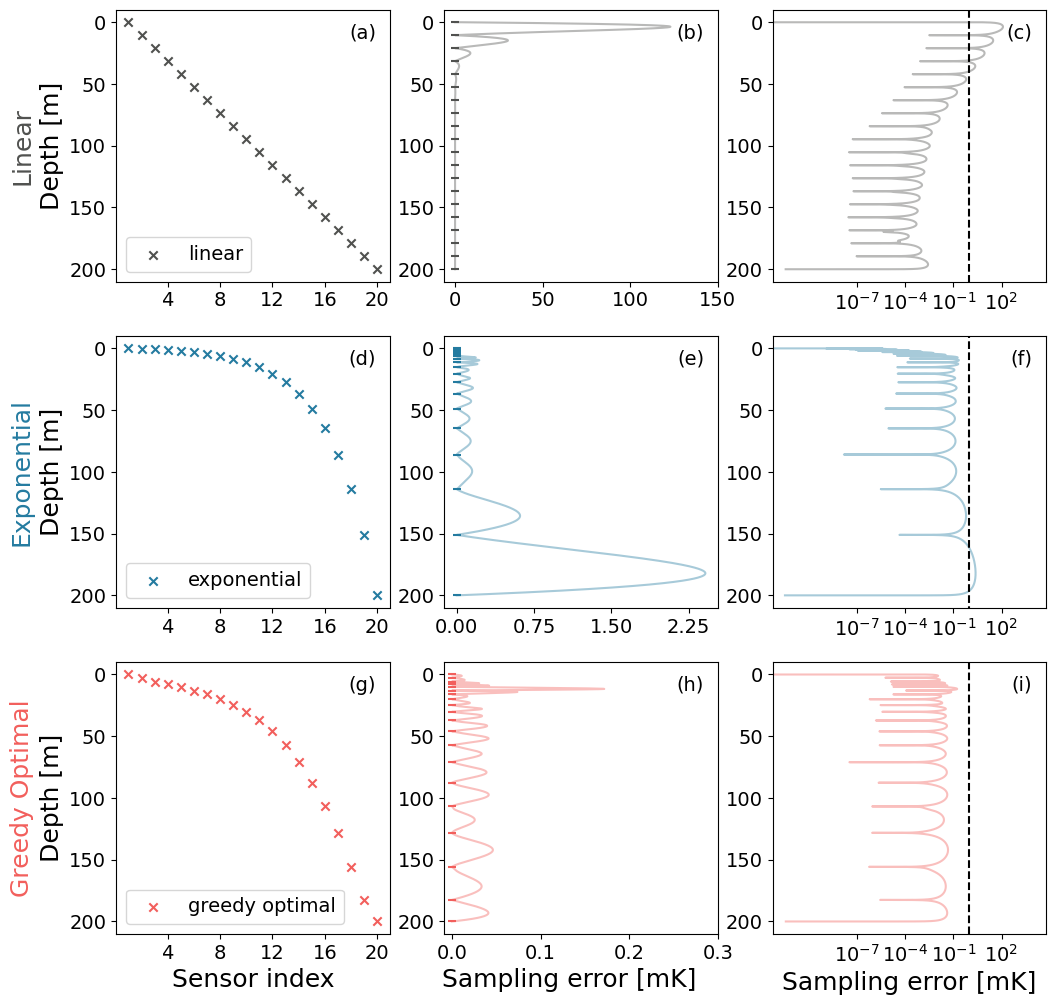

In [13]:
number_sens=[]
for i in range(sensor_count):
    number_sens.append(i+1)
    
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

left, width = 0, 0
bottom, height = .25, .5
right = left + width
top = bottom + height

plt.figure(figsize=(12, 12))


ax1 = plt.subplot2grid((3,3), (0, 0),colspan=1,rowspan=1)
ax1.scatter(number_sens,sensor_depths_linear,c='#50514f',alpha=1,marker='x', label='linear')
ax1.text(-0.3, 0.5 * (bottom + top), 'Linear',
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=ax1.transAxes,
        fontsize=18,
        c='#50514f')
ax1.set_ylabel("\nDepth [m]",fontsize=18)
ax1.invert_yaxis()
ax1.legend(fontsize=14,loc='lower left')
ax1.text(0.95, 0.95, '(a)', horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,fontsize=14)


ax2 = plt.subplot2grid((3,3), (0, 1),colspan=1,rowspan=1,sharey=ax1)
ax2.plot(accumulated_error_linear*1000,error_grid,c='#50514f',alpha=0.4, label="Mean error")
ax2.scatter(np.zeros(sensor_count),sensor_depths_linear,marker='_',c='#50514f',label='linear')
ax2.invert_yaxis()
ax2.set_xticks([0, 50,100,150])
ax2.text(0.95, 0.95, '(b)', horizontalalignment='right', verticalalignment='top', transform=ax2.transAxes,fontsize=14)

ax3 = plt.subplot2grid((3,3), (0, 2),colspan=1,rowspan=1, sharey=ax1)
ax3.plot(accumulated_error_linear,error_grid,c='#50514f',alpha=0.4, label="Mean error")
ax3.scatter(np.zeros(sensor_count),sensor_depths_linear,marker='_',c='#50514f',label='linear')
ax3.invert_yaxis()
ax3.set_xscale('log')
ax3.axvline(x=10**-3, ymin=200, ymax=0, color='black',linestyle='--')
ax3.text(0.95, 0.95, '(c)', horizontalalignment='right', verticalalignment='top', transform=ax3.transAxes,fontsize=14)


ax4 = plt.subplot2grid((3,3), (1, 0),colspan=1,rowspan=1, sharex=ax1, sharey=ax1)
ax4.scatter(number_sens,sensor_depths_logarthmic,c='#247ba0',alpha=1,marker='x',label='exponential')
ax4.set_ylabel("\nDepth [m]",fontsize=18)
ax4.text(-0.3, 0.5 * (bottom + top), 'Exponential',
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=ax4.transAxes,
        fontsize=18,
        c='#247ba0')
ax4.invert_yaxis()
ax4.legend(fontsize=14,loc='lower left')
ax4.text(0.95, 0.95, '(d)', horizontalalignment='right', verticalalignment='top', transform=ax4.transAxes,fontsize=14)

ax5 = plt.subplot2grid((3,3), (1, 1),colspan=1,rowspan=1, sharey=ax1)
ax5.plot(accumulated_error_logarthmic*1000,error_grid, c='#247ba0', alpha=0.4, label='exponential')
ax5.scatter(np.zeros(sensor_count),sensor_depths_logarthmic,marker='_',c='#247ba0',label='Sensor\npoints')
ax5.set_xticks([0, 0.75,1.5,2.25])
ax5.invert_yaxis()
ax5.text(0.95, 0.95, '(e)', horizontalalignment='right', verticalalignment='top', transform=ax5.transAxes,fontsize=14)


ax6 = plt.subplot2grid((3,3), (1, 2),colspan=1,rowspan=1, sharex=ax3, sharey=ax1)
ax6.plot(accumulated_error_logarthmic,error_grid, c='#247ba0', alpha=0.4, label='exponential')
ax6.invert_yaxis()
ax6.set_xscale('log')
ax6.axvline(x=10**-3, ymin=200, ymax=0, color='black',linestyle='--')
ax6.text(0.95, 0.95, '(f)', horizontalalignment='right', verticalalignment='top', transform=ax6.transAxes,fontsize=14)


ax7 = plt.subplot2grid((3,3), (2, 0),colspan=1,rowspan=1, sharex=ax1, sharey=ax1)
ax7.scatter(number_sens,sensor_depths_go_avg,c='#f25f5c',alpha=1,marker='x',label='greedy optimal')
ax7.set_ylabel("\nDepth [m]",fontsize=18)
ax7.text(-0.3, 0.5 * (bottom + top), 'Greedy Optimal',
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=ax7.transAxes,
        fontsize=18,
        c='#f25f5c')
ax7.set_xlabel("Sensor index",fontsize=18)
ax7.invert_yaxis()
ax7.legend(fontsize=14,loc='lower left')
ax7.text(0.95, 0.95, '(g)', horizontalalignment='right', verticalalignment='top', transform=ax7.transAxes,fontsize=14)
ax7.set_xticks([4, 8,12,16,20])


ax8 = plt.subplot2grid((3,3), (2, 1),colspan=1,rowspan=1, sharey=ax1)
ax8.plot(accumulated_error_go_avg*1000,error_grid, c='#f25f5c', alpha=0.4, label="greedy optimal")
ax8.scatter(np.zeros(sensor_count),sensor_depths_go_avg,marker='_',c='#f25f5c',label='Sensor\npoints')
ax8.set_xlabel("Sampling error [mK]   ",fontsize=18)
ax8.invert_yaxis()
ax8.set_xticks([0, 0.10,0.20,0.3])
ax8.text(0.95, 0.95, '(h)', horizontalalignment='right', verticalalignment='top', transform=ax8.transAxes,fontsize=14)
ax8.axvline(x=0.27, ymin=200, ymax=0, color='white',linestyle='--')

ax9= plt.subplot2grid((3,3), (2, 2),colspan=1,rowspan=1, sharex=ax3, sharey=ax1)
ax9.plot(accumulated_error_go_avg,error_grid, c='#f25f5c', alpha=0.4, label="greedy optimal")
ax9.set_xlabel("Sampling error [mK]",fontsize=18)
ax9.invert_yaxis()
ax9.set_xscale('log')
ax9.set_xticks([10**-10,10**-7,10**-4, 10**-1],labels=[r"$10^{-7}$",r"$10^{-4}$",r"$10^{-1}$", r"$10^{2}$"])
ax9.axvline(x=10**-3, ymin=200, ymax=0, color='black',linestyle='--')
ax9.text(0.95, 0.95, '(i)', horizontalalignment='right', verticalalignment='top', transform=ax9.transAxes,fontsize=14)
ax9.axvline(x=10**1, ymin=200, ymax=0, color='white',linestyle='--')